## IMDB predictor supported by MLFlow 

This notebook is demonstration whot to use MLFlow to track experiments, store artifacts and use stored data using Tensorbord

http://188.246.227.23:5000/#/models

Make sure you have configured environment variables: 

* `MLFLOW_HOST` should point to MLFLOW ui 
* `MLFLOW_S3_ENDPOINT_URL` should point to S3 endpoint (if it is not s3)

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.base import ClassifierMixin

class IMDBPredictor(ClassifierMixin):
    def __init__(self, model):
        self.model = model
        
    def predict(self, X):
        y_pred = self.model.predict(X)
        y_pred = ((y_pred + 0.5)//1).astype('int64')
        return y_pred

def create_model(max_features, maxlen):
    # Input for variable-length sequences of integers
    inputs = keras.Input(shape=(None,), dtype="int32")
    # Embed each integer in a 128-dimensional vector
    x = layers.Embedding(max_features, 128)(inputs)
    # Add 2 bidirectional LSTMs
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(64))(x)
    # Add a classifier
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    return model

## Prepare train-val data

In [2]:
 # Only consider the top 20k words
max_features = 20000
# Only consider the first 200 words of each movie review
maxlen = 200  

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

D:\Soft\Anaconda\envs\aiprocess\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
D:\Soft\Anaconda\envs\aiprocess\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


25000 Training sequences
25000 Validation sequences


## Run experiment

In [3]:
import mlflow, os
import mlflow.tensorflow
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [4]:
EXPERIMENT_NAME = '/prjx/imdb'
mlflow.set_tracking_uri(os.environ["MLFLOW_HOST"])
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment:
    experiment_id = experiment.experiment_id
else:
    # Possible to set up own s3 bucket artifact_location
    experiment_id = mlflow.create_experiment(name=EXPERIMENT_NAME)
print(f'Active experiment_id: {experiment_id}')

Active experiment_id: 1


D:\Soft\Anaconda\envs\aiprocess\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:820: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if (isinstance(inputs, collections.Sequence)
D:\Soft\Anaconda\envs\aiprocess\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/3


D:\Soft\Anaconda\envs\aiprocess\lib\site-packages\tensorflow\python\training\tracking\data_structures.py:718: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


782/782 [==============================] - 298s 381ms/step - loss: 0.3917 - accuracy: 0.8192 - val_loss: 0.3455 - val_accuracy: 0.8548
Epoch 2/3
782/782 [==============================] - 282s 361ms/step - loss: 0.1905 - accuracy: 0.9283 - val_loss: 0.3163 - val_accuracy: 0.8773
Epoch 3/3
782/782 [==============================] - 301s 385ms/step - loss: 0.0965 - accuracy: 0.9653 - val_loss: 0.3851 - val_accuracy: 0.8697


D:\Soft\Anaconda\envs\aiprocess\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


<Experiment: artifact_location='s3://mlflow/artefacts/1', experiment_id='1', lifecycle_stage='active', name='/prjx/imdb', tags={}>


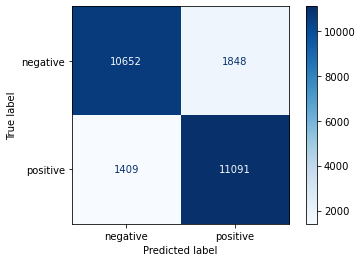

In [5]:
with mlflow.start_run(experiment_id=experiment_id):
    model = create_model(max_features=max_features, maxlen=maxlen)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    mlflow.tensorflow.autolog()
    model.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_val, y_val))
    
    # Log a parameter (key-value pair)
    mlflow.log_param("data_version", 'v2')
    
    
    # Log a metric; metrics can be updated throughout the run
    # mlflow.log_metric("foo", 3, step=1)
    
    # Log confusion matrix 
    predictor = IMDBPredictor(model)
    
    import matplotlib.pyplot as plt 
    plot_confusion_matrix(predictor, x_val, y_val,
                      display_labels=['negative', 'positive'],
                      cmap=plt.cm.Blues,
                      normalize=None)
    plt.savefig('confusion_matrix.png')
    mlflow.log_artifact('confusion_matrix.png')
    
    # Show experiment metadata
    experiment = mlflow.get_experiment(experiment_id)
    print(experiment)

## Tensorboard

Run tensorboard instance 

```
tensorboard --logdir s3://mlflow/artefacts/0/70251c20a0a74b63af9cddcefe7d5313/artifacts/tensorboard_logs
```

And go to 
http://localhost:6006/ 

In [6]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

tensorboard --logdir s3://mlflow/artefacts/1/cc618c80d17f47c29c48c379c1c5d457/artifacts/tensorboard_logs

Known TensorBoard instances:
  - port 6006: logdir logs (started 22:51:31 ago; pid 16464)
  - port 6006: logdir logs (started 20:56:49 ago; pid 20284)
  - port 6006: logdir s3://mlflow/artefacts/10/266992f3039d4bfcad9aff05695994c3/artifacts/tensorboard_logs (started 22:50:23 ago; pid 9644)


In [10]:
from tensorboard import notebook
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir logs (started 1 day, 18:03:18 ago; port 6006, pid 20284).
